## Day 25 Lecture 2 Assignment

In this assignment, we will extend a previous binary model to a multinomial case with three classes. We will use the FIFA soccer ratings dataset loaded below and analyze the model generated for this dataset.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm


import numpy as np
import pandas as pd

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    log_loss,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    make_scorer,
)
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, classification_report, log_loss

In [2]:
def remove_correlated_features(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in dataset.columns:
                    print(f'Deleted {colname} from dataset.')
                    del dataset[colname]

    return dataset

In [3]:
soccer_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/fifa_ratings.csv')

In [4]:
soccer_data.head()

,ID,Name,Overall,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,158023,L. Messi,94,84,95,70,90,86,97,93,...,94,48,22,94,94,75,96,33,28,26
1,20801,Cristiano Ronaldo,94,84,94,89,81,87,88,81,...,93,63,29,95,82,85,95,28,31,23
2,190871,Neymar Jr,92,79,87,62,84,84,96,88,...,82,56,36,89,87,81,94,27,24,33
3,192985,K. De Bruyne,91,93,82,55,92,82,86,85,...,91,76,61,87,94,79,88,68,58,51
4,183277,E. Hazard,91,81,84,61,89,80,95,83,...,80,54,41,87,89,86,91,34,27,22


Our response for our logistic regression model is going to be a new column, "RankingTier", that contains three categories:

- High: Overall score > 75
- Middle: Overall score between 65 and 75
- Low: Overall score < 65

In [5]:
# answer goes here
soccer_data["RankingTier"] = "High"
soccer_data.loc[soccer_data["Overall"] <= 75, "RankingTier"] = "Middle"
soccer_data.loc[soccer_data["Overall"] <= 65, "RankingTier"] = "Low"

soccer_data["RankingTier"].value_counts(normalize=True)
soccer_data = soccer_data.drop('Overall', axis=1)


In [6]:
soccer_data['RankingTier'].value_counts()

Middle    7597
Low       7110
High      1415
Name: RankingTier, dtype: int64

The next few steps until model training are the same as before: identify and remove highly correlated features, and split the data into a training set (80%) and a test set (20%).

In [7]:
# answer goes here
soccer_clean = remove_correlated_features(soccer_data, 0.9)

Deleted StandingTackle from dataset.
Deleted SlidingTackle from dataset.


In [8]:
X = soccer_clean.drop(columns=['ID', 'Name', 'RankingTier'])
y= soccer_clean['RankingTier']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42)

Fit a multinomial logistic regression model using the statsmodels package and print out the coefficient summary. What is the "reference" tier chosen by the model? How do we interpret the coefficients - for example, how does the intepretation of the "Reactions" coefficient for RankingTier=Low differ from the "Reactions" coefficient for RankingTier=Middle?

In [9]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# answer goes here
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
pd.DataFrame(model.coef_, columns=X.columns)

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking
0,-0.012600,0.428385,0.641045,1.507834,-0.193792,-0.009701,-0.005704,0.136179,-0.009085,1.519955,...,-0.028520,0.343675,-0.460340,0.150323,-0.336080,-0.654128,-0.515728,0.092707,1.159682,0.407003
1,-0.099781,-0.360203,-0.688774,-1.166316,0.185140,0.062100,-0.002667,-0.121508,-0.023507,-1.306000,...,-0.032285,-0.305983,0.323235,-0.125766,0.214683,0.513992,0.475146,-0.138756,-1.044233,-0.350006
2,0.112381,-0.068182,0.047730,-0.341518,0.008652,-0.052399,0.008371,-0.014671,0.032592,-0.213955,...,0.060806,-0.037692,0.137106,-0.024558,0.121396,0.140137,0.040581,0.046049,-0.115449,-0.056997


In [12]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.83      0.75      0.79       277
         Low       0.86      0.85      0.85      1415
      Middle       0.82      0.85      0.83      1533

    accuracy                           0.84      3225
   macro avg       0.84      0.81      0.83      3225
weighted avg       0.84      0.84      0.84      3225



To evaluate test error using cross-validation, we will switch back to scikit-learn. Estimate the test error of this multinomial logistic regression model using 10-fold CV.

Note: scikit-learn's LogisticRegression() function can handle both binary and multinomial regression, and it is automatically able to determine which is appropriate based on the y_train array that is passed. You should be able to reuse previous code with minimal changes required.

In [13]:
# answer goes here
cross_val_score(model, X_train, y_train, cv=5)

array([0.8255814 , 0.83914729, 0.83986041, 0.83443195, 0.83947266])

As we did in the previous exercise, train a multinomial logistic regression on the training data, make predictions on the 20% holdout test data, then:

- Determine the precision, recall, and F1-score of our model using a cutoff/threshold of 0.5 (hint: scikit-learn's *classification_report* function may be helpful)
- Plot or otherwise generate a confusion matrix
- Plot the ROC curve for our logistic regression model

Comment on the performance of the model.

In [21]:
# answer goes here
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=["pred_0", "pred_1", "pred_2"],
    index=["true_0", "true_1", "true_2"])




,pred_0,pred_1,pred_2
true_0,208,0,69
true_1,0,1196,219
true_2,42,192,1299


In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.83      0.75      0.79       277
         Low       0.86      0.85      0.85      1415
      Middle       0.82      0.85      0.83      1533

    accuracy                           0.84      3225
   macro avg       0.84      0.81      0.83      3225
weighted avg       0.84      0.84      0.84      3225



In [23]:
y_prob = model.predict_proba(X_test)

y_prob_hi = y_prob[:, 0]
y_prob_lo = y_prob[:, 1]
y_prob_mid = y_prob[:, 2]

In [24]:
roc_auc_score(y_test == "High", y_prob_hi)

0.9831630328828455

In [25]:
roc_auc_score(y_test == "Low", y_prob_lo)

0.951297268805029

In [26]:
roc_auc_score(y_test == "Middle", y_prob_mid)

0.9186613957089037

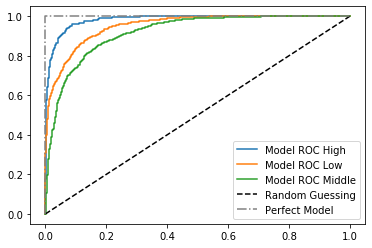

In [27]:
hi_fpr, hi_tpr, _ = roc_curve(y_test == "High", y_prob_hi)
lo_fpr, lo_tpr, _ = roc_curve(y_test == "Low", y_prob_lo)
mid_fpr, mid_tpr, _ = roc_curve(y_test == "Middle", y_prob_mid)

plt.plot(hi_fpr, hi_tpr, label="Model ROC High")
plt.plot(lo_fpr, lo_tpr, label="Model ROC Low")
plt.plot(mid_fpr, mid_tpr, label="Model ROC Middle")
plt.plot([0, 1], [0, 1], "--", c="black", label="Random Guessing")
plt.plot([0, 0, 1], [0, 1, 1], "-.", c="gray", label="Perfect Model")
plt.legend()
plt.show()